In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from Bio import SeqIO

# Amplicon reads

In [9]:
os.system("minimap2 -ax map-hifi data/data/SARS-CoV-2-NC_045513.fa data/data/real_data/trimmed_02_100.fastq > aln.sam")
os.system("samtools view -@ n -Sb -o aln.bam aln.sam")
os.system("samtools sort -@ n -o aln.sorted.bam aln.bam")
os.system("samtools index aln.sorted.bam")

[M::mm_idx_gen::0.004*4.10] collected minimizers
[M::mm_idx_gen::0.005*3.80] sorted minimizers
[M::main::0.005*3.79] loaded/built the index for 1 target sequence(s)
[M::mm_mapopt_update::0.005*3.71] mid_occ = 50
[M::mm_idx_stat] kmer size: 19; skip: 19; is_hpc: 0; #seq: 1
[M::mm_idx_stat::0.005*3.63] distinct minimizers: 3001 (100.00% are singletons); average occurrences: 1.000; average spacing: 9.941; total length: 29833
[M::worker_pipeline::7.065*2.00] mapped 33062 sequences
[M::main] Version: 2.26-r1175
[M::main] CMD: minimap2 -ax map-hifi data/data/SARS-CoV-2-NC_045513.fa data/data/real_data/trimmed_02_100.fastq
[M::main] Real time: 7.068 sec; CPU: 14.164 sec; Peak RSS: 0.111 GB


0

count    33049.000000
mean      1084.656268
std         43.844447
min        228.000000
25%       1064.000000
50%       1087.000000
75%       1108.000000
max       1199.000000
Name: length, dtype: float64
maximum read length:  1199


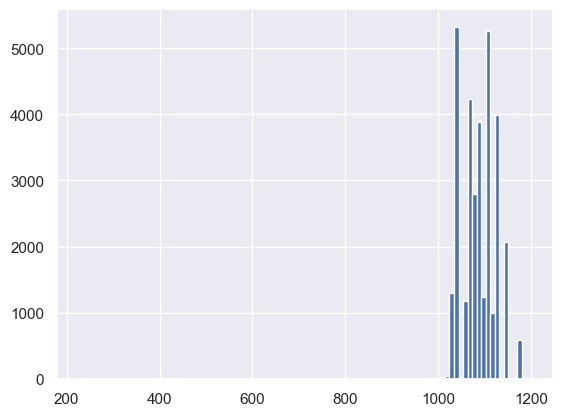

In [10]:
# produce bed file for the amplicon reads
os.system("bedtools bamtobed -i aln.sorted.bam > aln.sorted.bed")

# calculate the distribution of the read lengths
df = pd.read_csv("aln.sorted.bed", sep="\t", header=None)
df["length"] = df[2] - df[1]
print(df["length"].describe())

# plot the distribution of the read lengths
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
plt.hist(df["length"], bins=100)

print("maximum read length: ", df["length"].max())





In [ ]:
# plot the distribution of the read lengths
sns.set()
plt.figure(figsize=(12, 6))
sns.histplot(df["length"], bins=100)

sns.histplot(df["length"], bins=100)
# save the plot
plt.savefig("amplicon_read_length_distribution.png")

#  ONT reads

In [ ]:
os.system("minimap2 -ax map-ont data/data/SARS-CoV-2-NC_045513.fa data/data/hcov_global_2023-11-16_09-28/split_fasta/A/simulated_reads/EPI_ISL_408480/EPI_ISL_408480_0001.fastq > aln_ont.sam")
os.system("samtools view -@ n -Sb -o aln_ont.bam aln_ont.sam")
os.system("samtools sort -@ n -o aln_ont.sorted.bam aln_ont.bam")
os.system("samtools index aln_ont.sorted.bam")

Identify reads from the same genome that overlap

In [ ]:
# group reads that overlap given a bam file
os.system("bedtools bamtobed -i aln_ont.bam > aln_ont.bed")
os.system("bedtools sort -i aln_ont.bed > aln_ont.sorted.bed")

# read in the bed file
bed = pd.read_csv("aln_ont.sorted.bed", sep="\t", header=None)
bed.columns = ["ref", "start", "end", "read_name", "score", "strand"]


# create a dictionary of read names and the reads they overlap with
read_dict = {}

for i in range(len(bed)):
    for j in range(len(bed)):
        if bed.iloc[i, 3] != bed.iloc[j, 3]:
            # start_i < end_j  and end_i > start_j
            if bed.iloc[i, 1] < bed.iloc[j, 2] and bed.iloc[i, 2] > bed.iloc[j, 1]:
                if bed.iloc[i, 3] in read_dict:
                    read_dict[bed.iloc[i, 3]].add(bed.iloc[j, 3])
                else:
                    read_dict[bed.iloc[i, 3]] = {bed.iloc[j, 3]}



print(read_dict.keys())
print(read_dict["EPI_ISL_4084801_23"])


Identify the reads from different genomes that overlap with each other

In [ ]:
bed_file_1 = pd.read_csv("aln_ont.sorted.bed", sep="\t", header=None)
bed_file_2 = pd.read_csv("aln_ont.sorted.bed", sep="\t", header=None)

bed_file_1.columns = ["ref", "start", "end", "read_name", "score", "strand"]
bed_file_2.columns = ["ref", "start", "end", "read_name", "score", "strand"]

# create a dictionary of read names and the reads they overlap with

read_dict = {}

for i in range(len(bed_file_1)):
    for j in range(len(bed_file_2)):
            # start_i < end_j  and end_i > start_j
            if bed_file_1.iloc[i, 1] < bed_file_2.iloc[j, 2] and bed_file_1.iloc[i, 2] > bed_file_2.iloc[j, 1]:
                if bed_file_1.iloc[i, 3] in read_dict:
                    read_dict[bed_file_1.iloc[i, 3]].add(bed_file_2.iloc[j, 3])
                else:
                    read_dict[bed_file_1.iloc[i, 3]] = {bed_file_2.iloc[j, 3]}

# print(read_dict.keys())
print(read_dict["EPI_ISL_4084801_23"])




In [ ]:
# calculate the distribution of the read lengths for ont reads
df = pd.read_csv("aln_ont.sorted.bed", sep="\t", header=None)
df["length"] = df[2] - df[1]
print(df["length"].describe())

# plot the distribution of the read lengths
sns.set()
plt.figure(figsize=(12, 6))
sns.histplot(df["length"], bins=100)
# save the plot
plt.savefig("ont_read_length_distribution.png")

# Next regions 

In [ ]:
metadata_nr = "data/data/hcov_global_2023-11-16_09-28/metadata.tsv"
metadata = pd.read_csv(metadata_nr, sep="\t")

pango_lineage = metadata["pango_lineage"].value_counts()
GISAID_clade = metadata["GISAID_clade"].value_counts()

# pie plot of the pango lineage
plt.figure(figsize=(12, 6))
plt.pie(pango_lineage, labels=pango_lineage.index, autopct='%1.1f%%')
plt.title("Pango lineage")
plt.show()

# pie plot of the GISAID clade
plt.figure(figsize=(12, 6))
plt.pie(GISAID_clade, labels=GISAID_clade.index, autopct='%1.1f%%')
plt.title("GISAID clade")
plt.show()


# Next regions dataset

In [ ]:
# check if the the two metadata files contain any common strains
metadata_nr_1 = "data/data/hcov_global_2022-08-26_05-12/hcov_global.tsv"
metadata_nr_2 = "data/data/hcov_global_2023-11-16_09-28/metadata.tsv"

metadata_1 = pd.read_csv(metadata_nr_1, sep="\t")
metadata_2 = pd.read_csv(metadata_nr_2, sep="\t")

# check if the the two metadata files contain any common strains
print(set(metadata_1["strain"]).intersection(set(metadata_2["strain"])))
print(len(set(metadata_1["strain"]).intersection(set(metadata_2["strain"]))))

# remove the common strains from the 2022 metadata
metadata_1 = metadata_1[~metadata_1["strain"].isin(set(metadata_1["strain"]).intersection(set(metadata_2["strain"])))]
# remove reads that their lineage is not contained in metadata_2
metadata_1 = metadata_1[metadata_1["pango_lineage"].isin(set(metadata_2["pango_lineage"]))]
metadata_1.to_csv("data/data/hcov_global_2022-08-26_05-12/metadata.tsv", sep="\t", index=False)
# parse the fasta file
records = SeqIO.parse("data/data/hcov_global_2022-08-26_05-12/hcov_global.fasta", "fasta")

# clean contents of the sequences.fasta file
open("data/data/hcov_global_2022-08-26_05-12/sequences.fasta", "w").close()
cnt = 0
cnt2 = 0
for record in records:
    cnt2 += 1
    if record.id in set(metadata_1["strain"]):
        with open("data/data/hcov_global_2022-08-26_05-12/sequences.fasta", "a") as f:
            f.write(">" + record.id + "\n")
            f.write(str(record.seq) + "\n")    
            cnt += 1
   
print(cnt, len(set(metadata_1["strain"])),cnt2)

